In [16]:
from datasets import Dataset, Audio, DatasetDict
import pandas as pd
import os

# Define paths
dataset_dir = "/home/hkngae/COMP5412/NoisySpeechDataset"
metadata_file = os.path.join(dataset_dir, "metadata.csv")
first_n = 1000  # Number of examples to load for trial

# Check if metadata file exists and read its structure first
if os.path.exists(metadata_file):
    # Just peek at the first few rows to see the structure
    print("Metadata file columns:")
    print(pd.read_csv(metadata_file, nrows=1).columns.tolist())

    # Load only the first n examples from metadata for trial
    metadata_df = pd.read_csv(metadata_file).head(first_n)
    
    # Assuming columns like "noisy_file", "clean_file", "snr" exist
    # Adapt these column names to match your actual metadata structure
    dataset_dict = {
        "id": [str(i) for i in range(len(metadata_df))],
        "noisy_file": metadata_df["noisy_file"].tolist() if "noisy_file" in metadata_df.columns else [],
        "clean_file": metadata_df["clean_file"].tolist() if "clean_file" in metadata_df.columns else [],
        "snr": metadata_df["snr"].tolist() if "snr" in metadata_df.columns else []
    }
    
    # Create the dataset
    small_ds = Dataset.from_dict(dataset_dict)
    
    # Add audio loading functionality 
    if "noisy_file" in metadata_df.columns:
        small_ds = small_ds.cast_column("noisy_file", Audio(sampling_rate=16000))
    if "clean_file" in metadata_df.columns:
        small_ds = small_ds.cast_column("clean_file", Audio(sampling_rate=16000))
    
    # Inspect the small dataset
    print(f"Small dataset contains {len(small_ds)} examples")
    print(f"Features: {small_ds.features}")
    
else:
    print(f"Metadata file not found at {metadata_file}")
    print("Please check the path or create the metadata file.")

Metadata file columns:
['noisy_file', 'clean_file', 'noise_file', 'snr']
Small dataset contains 1000 examples
Features: {'id': Value(dtype='string', id=None), 'noisy_file': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'clean_file': Audio(sampling_rate=16000, mono=True, decode=True, id=None), 'snr': Value(dtype='int64', id=None)}


Noisy audio sample rate: 16000 Hz
Noisy audio duration: 7.64 seconds


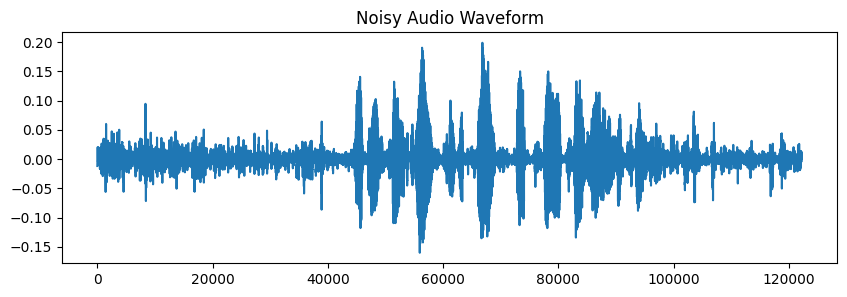

Noisy Audio:



Clean audio sample rate: 16000 Hz
Clean audio duration: 7.64 seconds


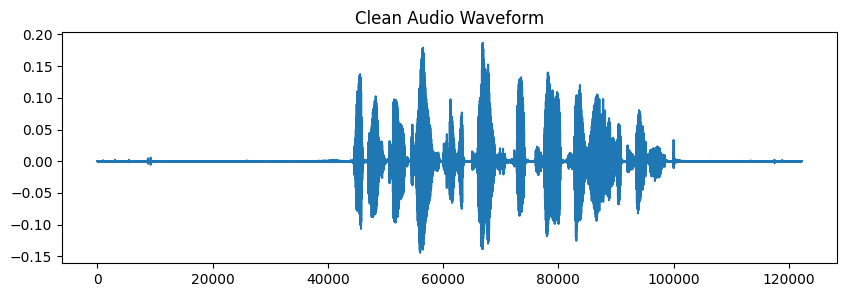

Clean Audio:


In [17]:
from IPython.display import Audio, display
import matplotlib.pyplot as plt

# Get a sample from the dataset
sample_idx = 9  # Change this to listen to different samples
if len(small_ds) > sample_idx:
    sample = small_ds[sample_idx]
    
    # Get the audio arrays and sampling rate
    if "noisy_file" in sample:
        noisy_audio = sample["noisy_file"]["array"]
        sr = sample["noisy_file"]["sampling_rate"]
        print(f"Noisy audio sample rate: {sr} Hz")
        print(f"Noisy audio duration: {len(noisy_audio)/sr:.2f} seconds")
        
        # Display waveform
        plt.figure(figsize=(10, 3))
        plt.plot(noisy_audio)
        plt.title("Noisy Audio Waveform")
        plt.show()
        
        # Create audio player
        print("Noisy Audio:")
        display(Audio(noisy_audio, rate=sr))
    
    if "clean_file" in sample:
        clean_audio = sample["clean_file"]["array"]
        sr = sample["clean_file"]["sampling_rate"]
        print(f"\nClean audio sample rate: {sr} Hz")
        print(f"Clean audio duration: {len(clean_audio)/sr:.2f} seconds")
        
        # Display waveform
        plt.figure(figsize=(10, 3))
        plt.plot(clean_audio)
        plt.title("Clean Audio Waveform")
        plt.show()
        
        # Create audio player
        print("Clean Audio:")
        display(Audio(clean_audio, rate=sr))
else:
    print("No samples available to play.")

In [18]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

class RawAudioDenoisingDataset(Dataset):
    def __init__(self, hf_dataset, fixed_length=None, normalize=True, augment=False):
        self.dataset = hf_dataset
        self.fixed_length = fixed_length  # Set to None to keep original lengths
        self.normalize = normalize
        self.augment = augment
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        sample = self.dataset[idx]
        
        # Get audio data
        noisy_audio = sample["noisy_file"]["array"].astype(np.float32)
        clean_audio = sample["clean_file"]["array"].astype(np.float32)
        
        # Data augmentation (optional)
        if self.augment:
            noisy_audio = self._augment_audio(noisy_audio)
        
        # Handle different lengths
        if self.fixed_length is not None:
            noisy_audio = self._adjust_length(noisy_audio, self.fixed_length)
            clean_audio = self._adjust_length(clean_audio, self.fixed_length)
        
        # Normalize if requested
        if self.normalize:
            noisy_audio = self._normalize_audio(noisy_audio)
            clean_audio = self._normalize_audio(clean_audio)
        
        # Convert to tensors
        noisy_tensor = torch.tensor(noisy_audio, dtype=torch.float32)
        clean_tensor = torch.tensor(clean_audio, dtype=torch.float32)
        
        return {
            "noisy": noisy_tensor,
            "clean": clean_tensor,
            "original_length": len(sample["noisy_file"]["array"])
        }
    
    def _adjust_length(self, audio, target_length): #2 seconds at 16kHz
        """Adjust audio to target length by padding or truncating"""
        if len(audio) > target_length:
            # Randomly select a segment of target_length
            start = np.random.randint(0, len(audio) - target_length)
            audio = audio[start:start+target_length]
        else:
            # Pad with zeros to target_length
            padding = target_length - len(audio)
            audio = np.pad(audio, (0, padding))
        return audio
    
    def _normalize_audio(self, audio):
        """Normalize audio to the range [-1, 1]"""
        if np.max(np.abs(audio)) > 0:
            return audio / np.max(np.abs(audio))
        return audio
    
    def _augment_audio(self, audio):
        """Apply simple augmentations to audio"""
        # Random gain
        gain = np.random.uniform(0.8, 1.2)
        return audio * gain

# Define a collate function for handling batches with variable lengths
def variable_length_collate(batch):
    # Find the maximum length in this batch
    max_len = max([item["noisy"].shape[0] for item in batch])
    
    # Prepare lists for batch data
    noisy_batch = []
    clean_batch = []
    lengths = []
    
    # Pad all samples to the max length
    for item in batch:
        noisy = item["noisy"]
        clean = item["clean"]
        lengths.append(len(noisy))
        
        # Pad if needed
        if len(noisy) < max_len:
            noisy_padded = torch.nn.functional.pad(noisy, (0, max_len - len(noisy)))
            clean_padded = torch.nn.functional.pad(clean, (0, max_len - len(clean)))
            noisy_batch.append(noisy_padded)
            clean_batch.append(clean_padded)
        else:
            noisy_batch.append(noisy)
            clean_batch.append(clean)
    
    # Stack into tensors
    noisy_batch = torch.stack(noisy_batch)
    clean_batch = torch.stack(clean_batch)
    lengths = torch.tensor(lengths)
    
    return {
        "noisy": noisy_batch,
        "clean": clean_batch,
        "lengths": lengths
    }

# Create train/val/test splits
train_ds, test_ds = small_ds.train_test_split(test_size=0.2, seed=42).values()
train_ds, val_ds = train_ds.train_test_split(test_size=0.25, seed=42).values()

# Set a fixed length for training (e.g., 2 seconds of audio at 16kHz = 32000 samples)
# Or set to None to keep variable length with padding in batches
fixed_length = None  # 32000  # Use a fixed length like this, or None for variable length

# Create datasets
train_dataset = RawAudioDenoisingDataset(train_ds, fixed_length=fixed_length, augment=True)
val_dataset = RawAudioDenoisingDataset(val_ds, fixed_length=fixed_length)
test_dataset = RawAudioDenoisingDataset(test_ds, fixed_length=fixed_length)

# Create data loaders
batch_size = 10
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    collate_fn=variable_length_collate if fixed_length is None else None
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    collate_fn=variable_length_collate if fixed_length is None else None
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    collate_fn=variable_length_collate if fixed_length is None else None
)

# Verify a batch
for batch in train_loader:
    print(f"Noisy audio shape: {batch['noisy'].shape}")
    print(f"Clean audio shape: {batch['clean'].shape}")
    if fixed_length is None:
        print(f"Sequence lengths: {batch['lengths']}")
    break

Noisy audio shape: torch.Size([10, 150720])
Clean audio shape: torch.Size([10, 150720])
Sequence lengths: tensor([109920, 106080, 150720, 122240, 150720, 138560, 122240, 138400, 109920,
        138400])


Dataset sizes:
Train: 600 samples
Validation: 200 samples
Test: 200 samples

Raw audio sample:
Noisy audio shape: torch.Size([122240])
Clean audio shape: torch.Size([122240])
{'noisy': tensor([[ 0.0004,  0.0012,  0.0006,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1209, -0.0799, -0.0514,  ...,  0.0123, -0.0908,  0.0091],
        [ 0.0077,  0.0160,  0.0270,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0173,  0.0143,  0.0132,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0207, -0.0233, -0.0232,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0005, -0.0002, -0.0006,  ...,  0.0000,  0.0000,  0.0000]]), 'clean': tensor([[ 6.1554e-04,  1.3947e-03,  7.3813e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 2.4244e-05, -8.6093e-04, -7.0487e-04,  ...,  6.1142e-04,
          7.0243e-04,  7.4366e-04],
        [-7.6627e-05, -9.9471e-06,  1.7405e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-4.3110e-04, -6.5862e-04,  1.8491e-04,  

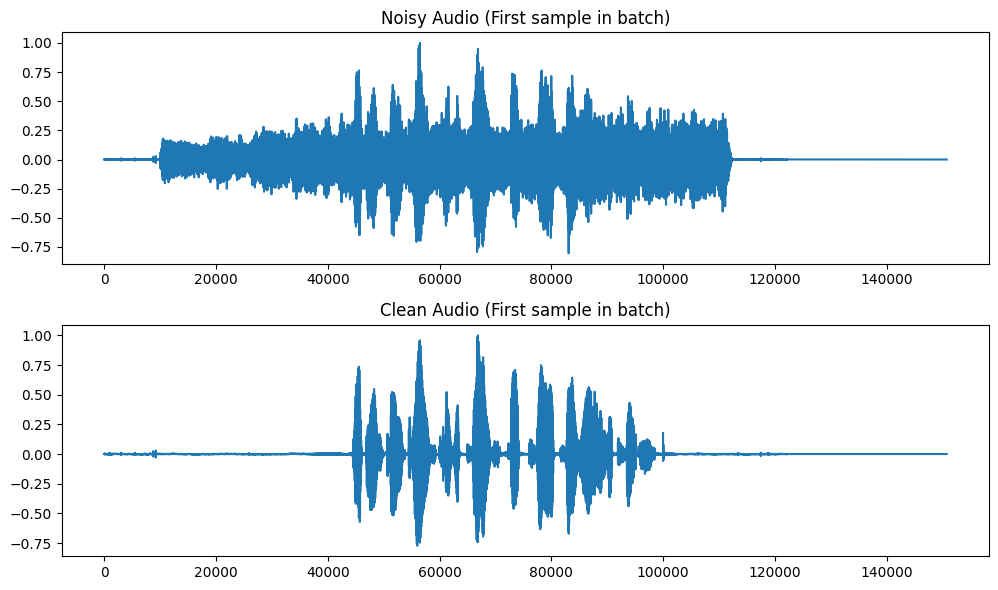

In [ ]:
# Test the dataset loaders
print("Dataset sizes:")
print(f"Train: {len(train_dataset)} samples")
print(f"Validation: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

# Get and inspect a sample from the training dataset
sample = train_dataset[0]
print("\nRaw audio sample:")
print(f"Noisy audio shape: {sample['noisy'].shape}")
print(f"Clean audio shape: {sample['clean'].shape}")

# Visualize a training batch
for batch in train_loader:
    print("\nBatch info:")
    print(f"Noisy batch shape: {batch['noisy'].shape}")
    print(f"Clean batch shape: {batch['clean'].shape}")
    
    # Plot the first sample in the batch
    plt.figure(figsize=(10, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(batch['noisy'][0].numpy())
    plt.title("Noisy Audio (First sample in batch)")
    
    plt.subplot(2, 1, 2)
    plt.plot(batch['clean'][0].numpy())
    plt.title("Clean Audio (First sample in batch)")
    
    plt.tight_layout()
    plt.show()
    break

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Inception1DBlock(nn.Module):
    """Inception block for 1D audio signals with multiple kernel sizes in parallel"""
    def __init__(self, in_channels, out_channels):
        super(Inception1DBlock, self).__init__()
        
        # Different kernel sizes to capture patterns at multiple time scales
        self.branch1x1 = nn.Conv1d(in_channels, out_channels//4, kernel_size=1)
        
        self.branch3x3_1 = nn.Conv1d(in_channels, out_channels//4, kernel_size=1)
        self.branch3x3_2 = nn.Conv1d(out_channels//4, out_channels//4, kernel_size=3, padding=1)
        
        self.branch5x5_1 = nn.Conv1d(in_channels, out_channels//4, kernel_size=1)
        self.branch5x5_2 = nn.Conv1d(out_channels//4, out_channels//4, kernel_size=5, padding=2)
        
        self.branch_pool = nn.Conv1d(in_channels, out_channels//4, kernel_size=1)
        
        self.bn = nn.BatchNorm1d(out_channels)
        
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        
        branch_pool = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        
        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        output = torch.cat(outputs, 1)
        output = F.relu(self.bn(output))
        
        return output

class InceptionFCN(nn.Module):
    """Fully Convolutional Network with Inception blocks for audio denoising"""
    def __init__(self, residual_learning=True):
        super(InceptionFCN, self).__init__()
        
        self.residual_learning = residual_learning
        
        # Initial convolution
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        
        # Downsample path
        self.inception1 = Inception1DBlock(16, 32)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.inception2 = Inception1DBlock(32, 64)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.inception3 = Inception1DBlock(64, 128)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Center block
        self.inception4 = Inception1DBlock(128, 256)
        
        # Upsample path with skip connections
        self.upconv3 = nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1)
        self.inception5 = Inception1DBlock(256, 128)  # 256 = 128 + 128 from skip connection
        
        self.upconv2 = nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1)
        self.inception6 = Inception1DBlock(128, 64)   # 128 = 64 + 64 from skip connection
        
        self.upconv1 = nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1)
        self.inception7 = Inception1DBlock(64, 32)    # 64 = 32 + 32 from skip connection
        
        # Final convolution
        self.conv_final = nn.Conv1d(32, 1, kernel_size=1)
        
    def forward(self, x):
        # Reshape input from [batch, time] to [batch, channels, time]
        x = x.unsqueeze(1)
        
        # If using residual learning, store the input for later
        input_audio = x if self.residual_learning else None
        
        # Initial convolution
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Downsample path
        skip1 = self.inception1(x)
        x = self.pool1(skip1)
        
        skip2 = self.inception2(x)
        x = self.pool2(skip2)
        
        skip3 = self.inception3(x)
        x = self.pool3(skip3)
        
        # Center block
        x = self.inception4(x)
        
        # Upsample path with skip connections
        x = self.upconv3(x)
        # Handle potential size mismatch in skip connections
        if x.size() != skip3.size():
            x = F.interpolate(x, size=skip3.size(2), mode='linear', align_corners=False)
        x = torch.cat([x, skip3], dim=1)
        x = self.inception5(x)
        
        x = self.upconv2(x)
        if x.size() != skip2.size():
            x = F.interpolate(x, size=skip2.size(2), mode='linear', align_corners=False)
        x = torch.cat([x, skip2], dim=1)
        x = self.inception6(x)
        
        x = self.upconv1(x)
        if x.size() != skip1.size():
            x = F.interpolate(x, size=skip1.size(2), mode='linear', align_corners=False)
        x = torch.cat([x, skip1], dim=1)
        x = self.inception7(x)
        
        # Final convolution
        x = self.conv_final(x)
        
        # Apply residual learning if enabled
        if self.residual_learning:
            # Handle potential size mismatch between input and output
            if x.size() != input_audio.size():
                input_audio = F.interpolate(input_audio, size=x.size(2), mode='linear', align_corners=False)
            x = input_audio - x  # Model predicts the noise, which we subtract
        
        # Reshape output from [batch, channels, time] back to [batch, time]
        return x.squeeze(1)

# Create and initialize the model
model = InceptionFCN(residual_learning=True)

# Test with a sample batch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Get a sample batch
for batch in train_loader:
    noisy = batch['noisy'].to(device)
    clean = batch['clean'].to(device)
    
    # Forward pass
    output = model(noisy)
    
    print(f"Input shape: {noisy.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Target shape: {clean.shape}")
    break

# Setup loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Input shape: torch.Size([10, 138560])
Output shape: torch.Size([10, 138560])
Target shape: torch.Size([10, 138560])


In [22]:
# Training loop
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch in train_loader:
            noisy = batch['noisy'].to(device)
            clean = batch['clean'].to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(noisy)
            
            # Calculate loss
            loss = criterion(outputs, clean)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * noisy.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch in val_loader:
                noisy = batch['noisy'].to(device)
                clean = batch['clean'].to(device)
                
                outputs = model(noisy)
                loss = criterion(outputs, clean)
                
                val_loss += loss.item() * noisy.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}')
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
    
    return model

# Train the model
num_epochs = 10
model = train(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/10:
Train Loss: 0.010456, Validation Loss: 0.002561
Epoch 2/10:
Train Loss: 0.002165, Validation Loss: 0.001851
Epoch 3/10:
Train Loss: 0.001719, Validation Loss: 0.001540
Epoch 4/10:
Train Loss: 0.001491, Validation Loss: 0.001503
Epoch 5/10:
Train Loss: 0.001401, Validation Loss: 0.001249
Epoch 6/10:
Train Loss: 0.001314, Validation Loss: 0.001284
Epoch 7/10:
Train Loss: 0.001222, Validation Loss: 0.001378
Epoch 8/10:
Train Loss: 0.001137, Validation Loss: 0.001099
Epoch 9/10:
Train Loss: 0.001117, Validation Loss: 0.001036
Epoch 10/10:
Train Loss: 0.001076, Validation Loss: 0.000997


Test Loss: 0.000966
Average SNR before denoising: 8.40 dB
Average SNR after denoising: 10.81 dB
Average SNR improvement: 2.42 dB


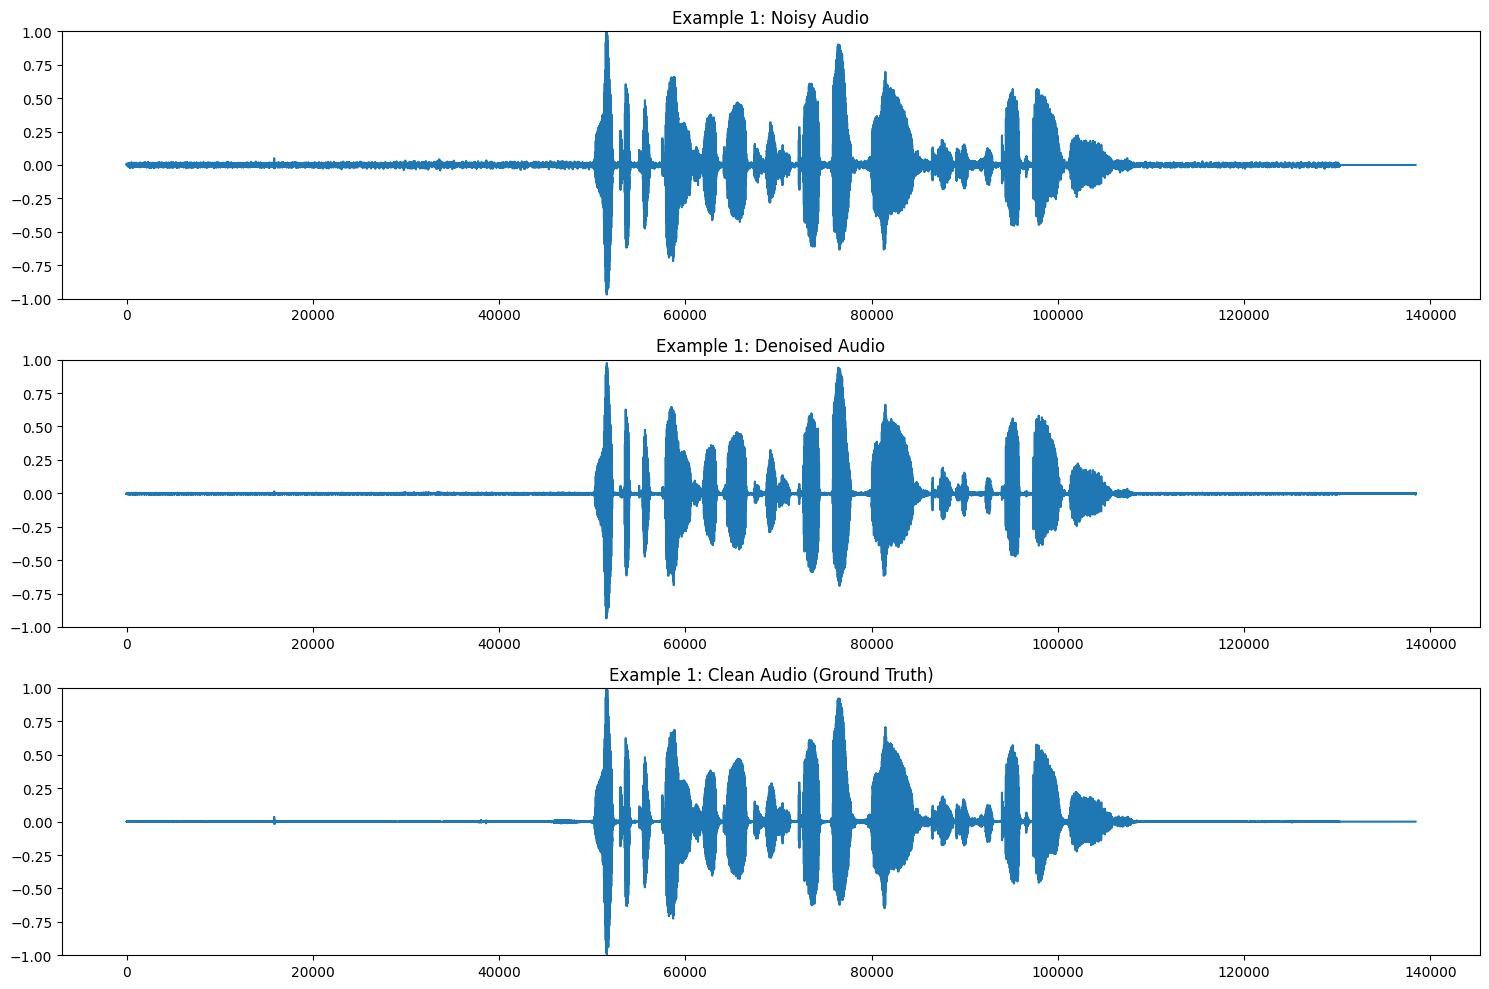


Example 1 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


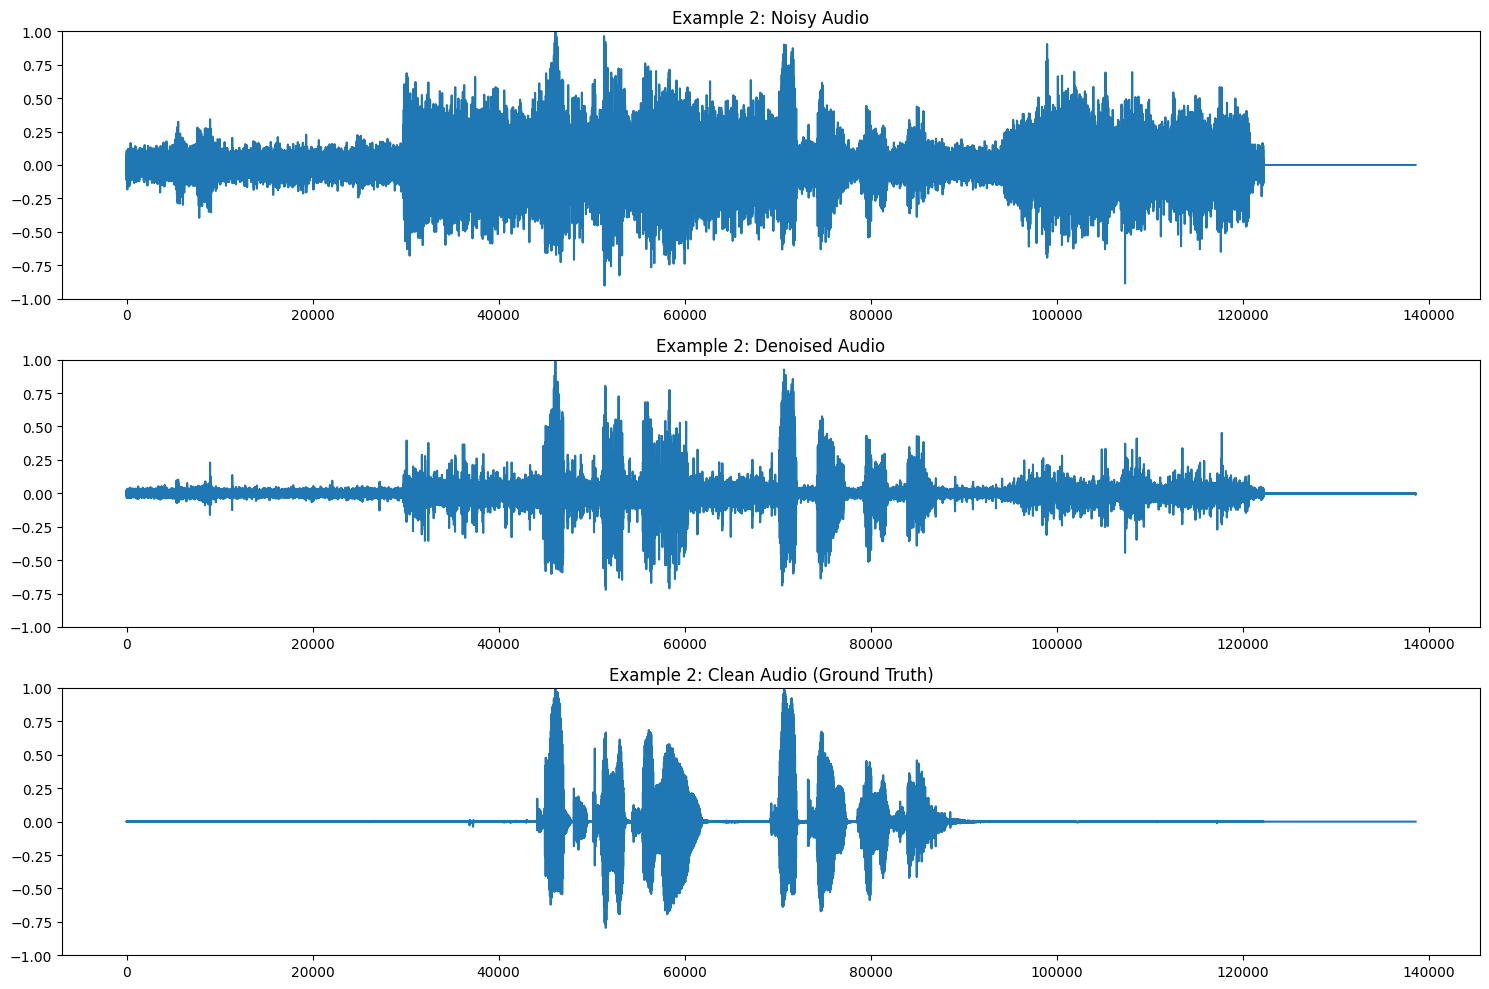


Example 2 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


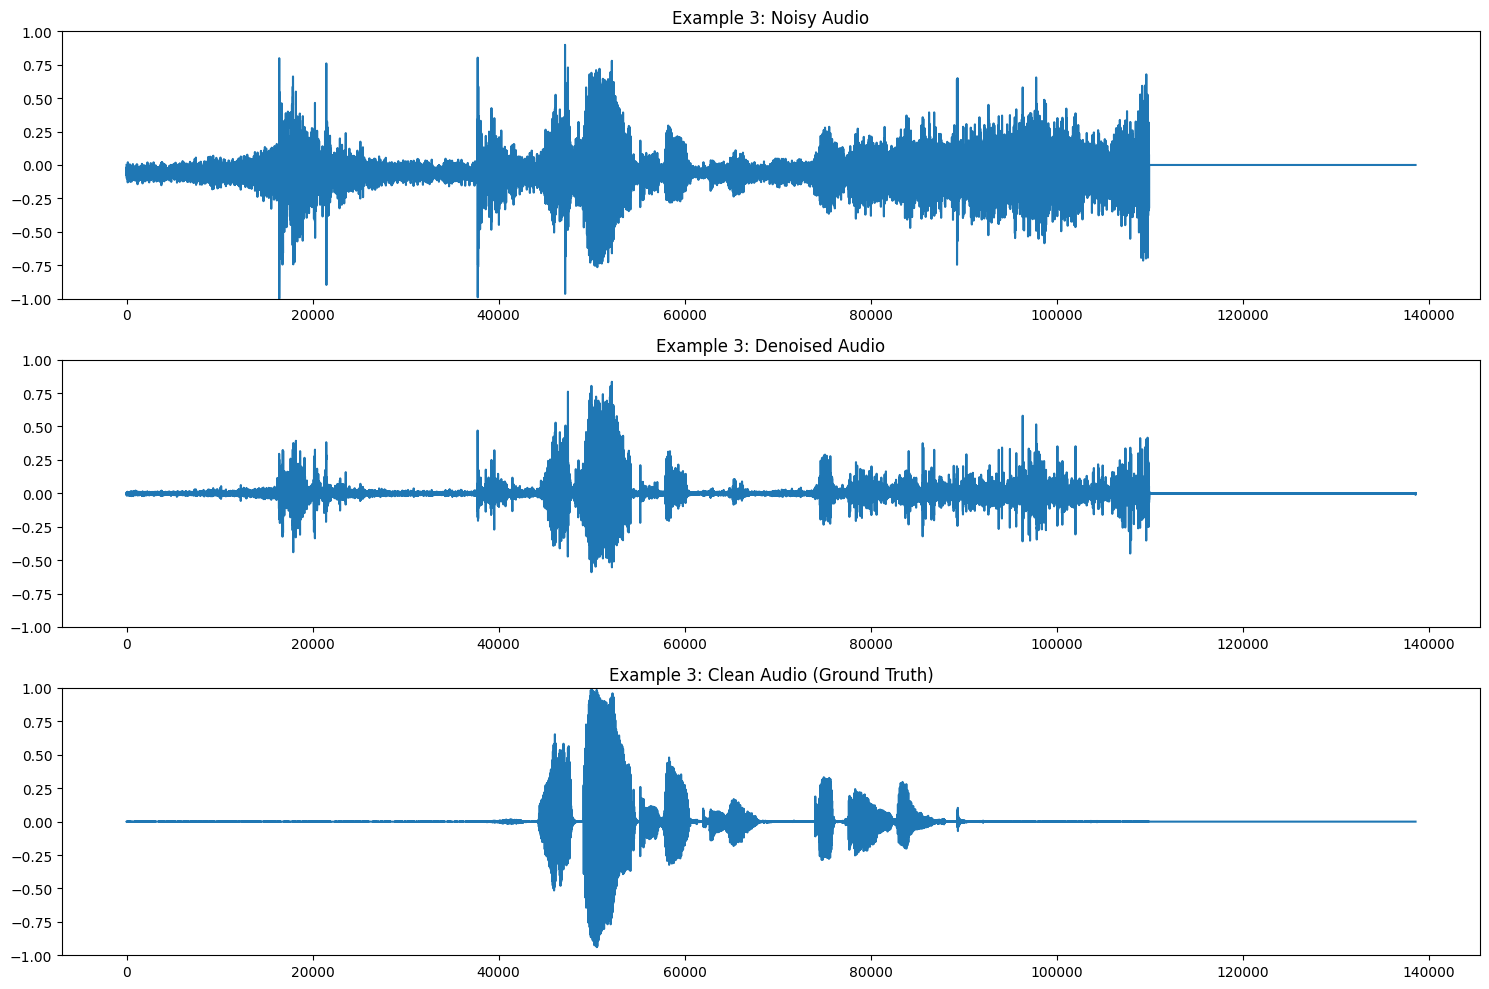


Example 3 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


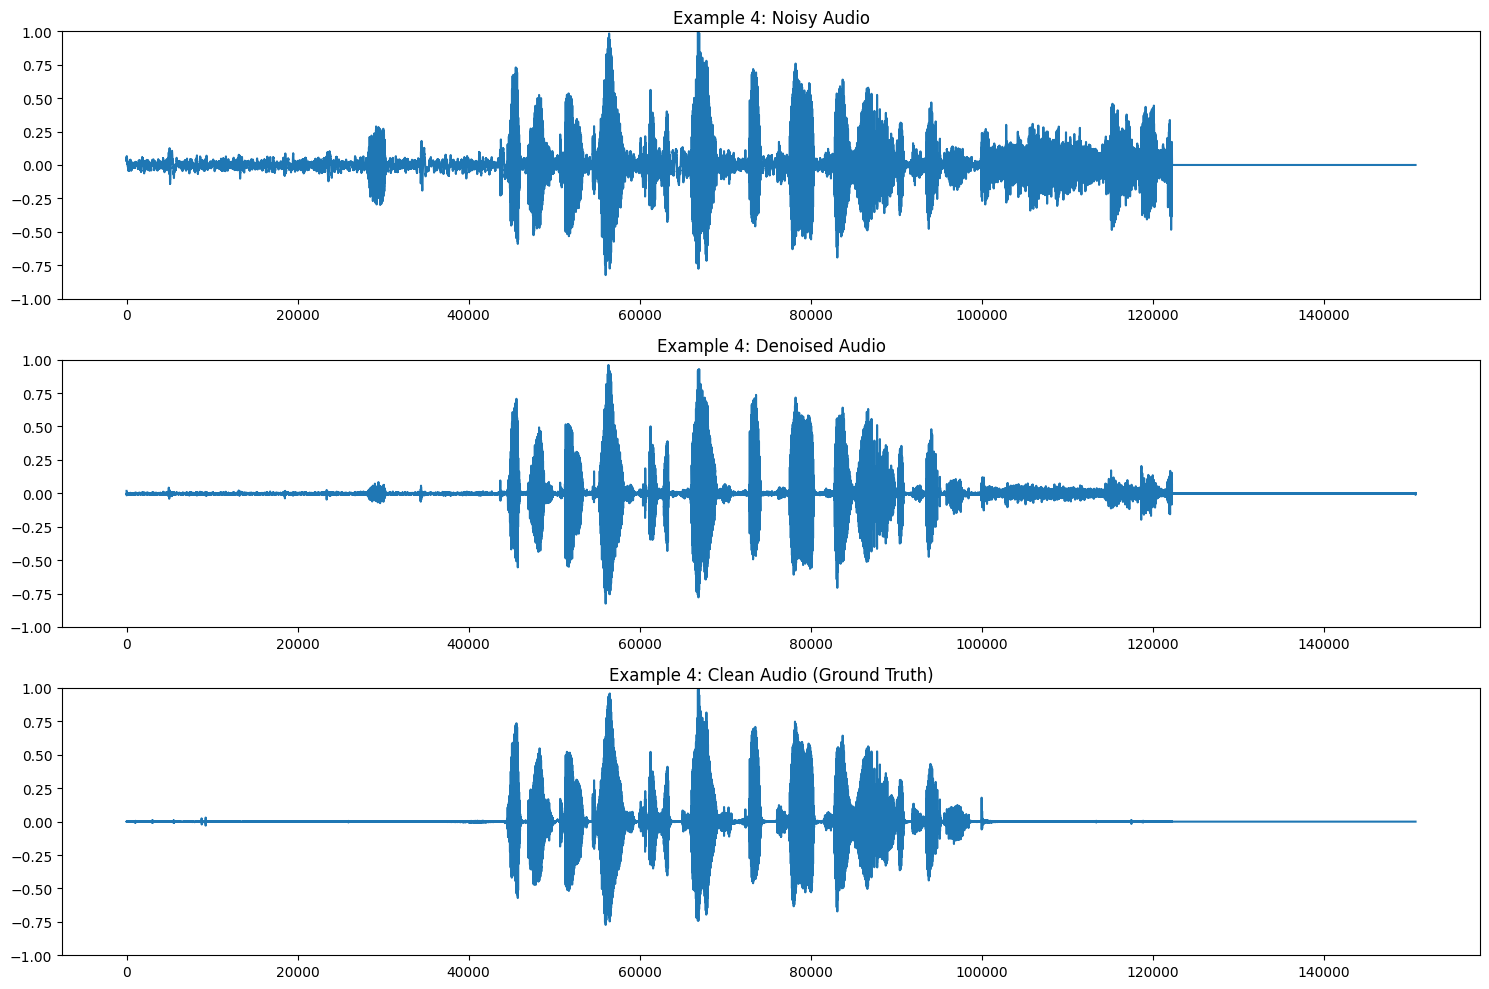


Example 4 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


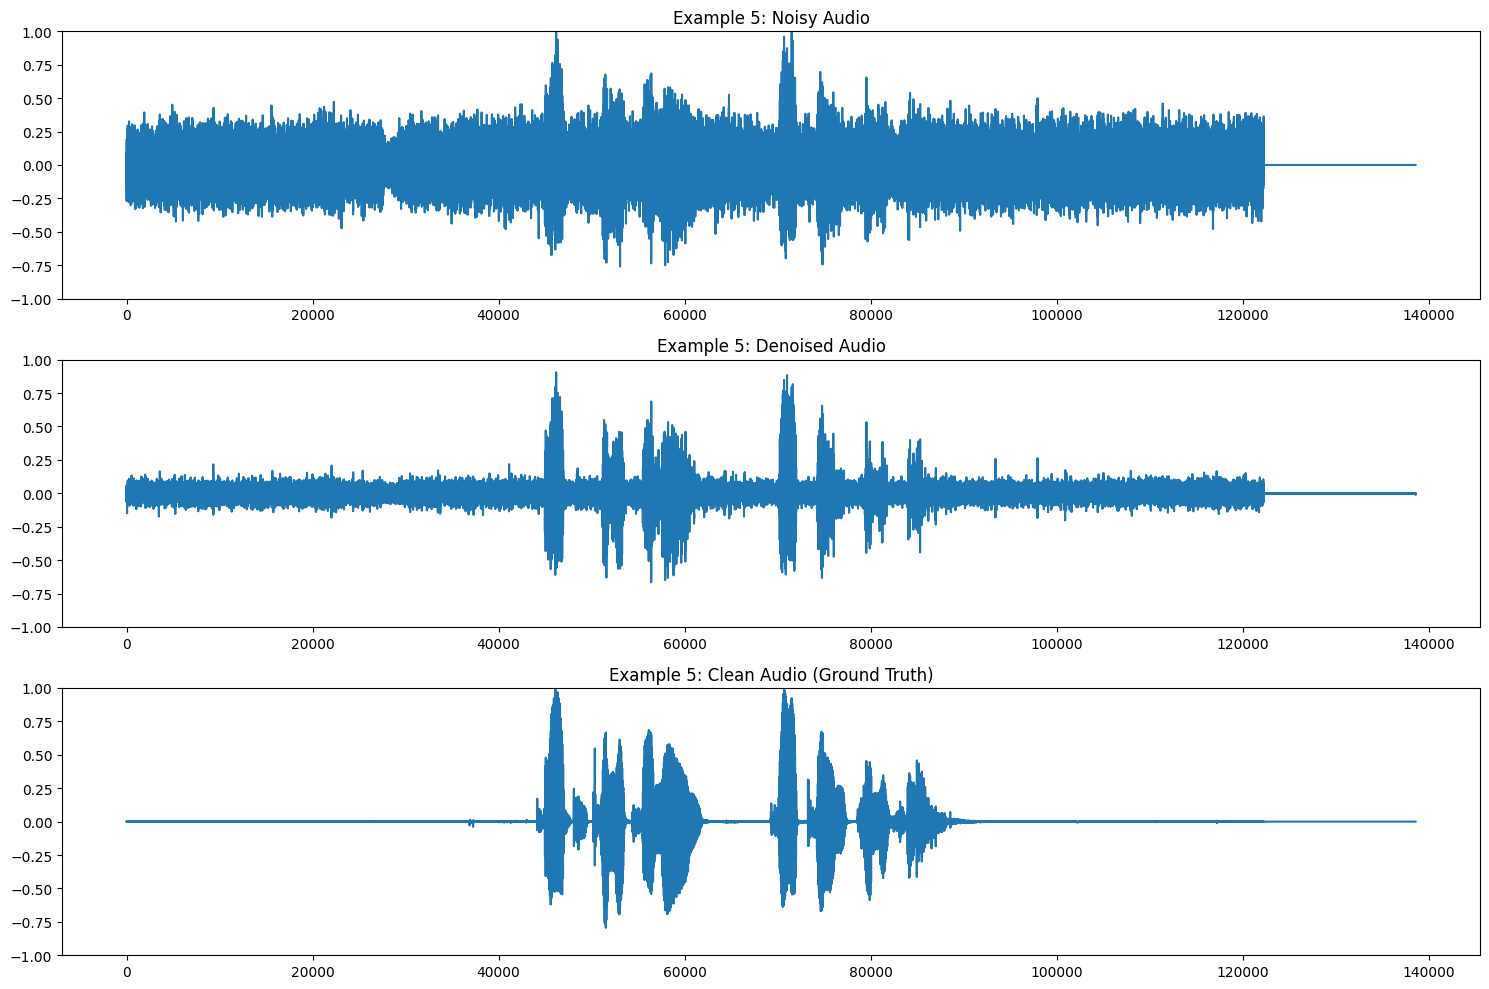


Example 5 - Audio playback:
Noisy Audio:


Denoised Audio:


Clean Audio (Ground Truth):


In [23]:
def test_model(model, test_loader, criterion=None, save_examples=True, num_examples=5):
    """
    Test the denoising model and compute metrics
    
    Args:
        model: The trained model
        test_loader: DataLoader for test data
        criterion: Loss function (optional)
        save_examples: Whether to save example denoised files
        num_examples: Number of examples to visualize and save
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Load best model weights
    model.load_state_dict(torch.load('best_model.pth'))
    
    test_loss = 0.0
    all_snr_before = []
    all_snr_after = []
    examples = []
    
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            noisy = batch['noisy'].to(device)
            clean = batch['clean'].to(device)
            
            # Forward pass
            denoised = model(noisy)
            
            # Store some examples
            if i < num_examples:
                examples.append({
                    'noisy': noisy[0].cpu().numpy(),
                    'clean': clean[0].cpu().numpy(),
                    'denoised': denoised[0].cpu().numpy()
                })
            
            # Calculate metrics
            if criterion:
                loss = criterion(denoised, clean)
                test_loss += loss.item() * noisy.size(0)
            
            # Calculate SNR before and after denoising
            for j in range(noisy.size(0)):
                # Original SNR
                noise = noisy[j].cpu().numpy() - clean[j].cpu().numpy()
                signal_power = np.mean(clean[j].cpu().numpy() ** 2)
                noise_power = np.mean(noise ** 2)
                snr_before = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')
                
                # SNR after denoising
                noise_after = denoised[j].cpu().numpy() - clean[j].cpu().numpy()
                noise_power_after = np.mean(noise_after ** 2)
                snr_after = 10 * np.log10(signal_power / noise_power_after) if noise_power_after > 0 else float('inf')
                
                all_snr_before.append(snr_before)
                all_snr_after.append(snr_after)
    
    # Calculate average metrics
    if criterion:
        avg_loss = test_loss / len(test_loader.dataset)
        print(f'Test Loss: {avg_loss:.6f}')
    
    avg_snr_before = np.mean(all_snr_before)
    avg_snr_after = np.mean(all_snr_after)
    snr_improvement = avg_snr_after - avg_snr_before
    
    print(f'Average SNR before denoising: {avg_snr_before:.2f} dB')
    print(f'Average SNR after denoising: {avg_snr_after:.2f} dB')
    print(f'Average SNR improvement: {snr_improvement:.2f} dB')
    
    # Visualize examples
    for i, example in enumerate(examples):
        plt.figure(figsize=(15, 10))
        
        # Plot waveforms
        plt.subplot(3, 1, 1)
        plt.plot(example['noisy'])
        plt.title(f'Example {i+1}: Noisy Audio')
        plt.ylim(-1, 1)
        
        plt.subplot(3, 1, 2)
        plt.plot(example['denoised'])
        plt.title(f'Example {i+1}: Denoised Audio')
        plt.ylim(-1, 1)
        
        plt.subplot(3, 1, 3)
        plt.plot(example['clean'])
        plt.title(f'Example {i+1}: Clean Audio (Ground Truth)')
        plt.ylim(-1, 1)
        
        plt.tight_layout()
        plt.show()
        
        # Create audio players
        sr = 16000  # Assuming 16kHz sample rate
        print(f"\nExample {i+1} - Audio playback:")
        
        print("Noisy Audio:")
        display(Audio(example['noisy'], rate=sr))
        
        print("Denoised Audio:")
        display(Audio(example['denoised'], rate=sr))
        
        print("Clean Audio (Ground Truth):")
        display(Audio(example['clean'], rate=sr))
        
        # Save audio files
        if save_examples:
            import soundfile as sf
            os.makedirs('denoised_examples', exist_ok=True)
            sf.write(f'denoised_examples/example_{i+1}_noisy.wav', example['noisy'], sr)
            sf.write(f'denoised_examples/example_{i+1}_denoised.wav', example['denoised'], sr)
            sf.write(f'denoised_examples/example_{i+1}_clean.wav', example['clean'], sr)
    
    return {
        'loss': avg_loss if criterion else None,
        'snr_before': avg_snr_before,
        'snr_after': avg_snr_after,
        'snr_improvement': snr_improvement,
        'examples': examples
    }

# Run the test
test_results = test_model(model, test_loader, criterion)